**CoronaVirus and Testing**

This notebook is authored by Percy Brown and Ndze'dzenyuy Lemfon, in view of completing the final project for the Data Science Class at Ashesi University, taught by Professor Allen Downey. 

The motivation for this project comes from a [ Twitter thread](https://twitter.com/MaxCRoser/status/1322841373251350528) by Max Roser from our World in Data. In this thread, Max argues that the best approach to containing the virus is one that tests appropriately. He provides an approach that could be used to measure how effectively countries are testing. 

The idea is that like South Korea and other countries that have contained
 the virus better than the rest of the world, a large number of tests are carried for each reported case of COVID-19. The ratio of positive cases to the number of tests in these countries can be well below 1%. A country is, therefore, said to be testing effectively if the ratio of it's total positive cases to its total number of tests carried out is small. 

In this project, we attempt to answer two questions. Firstly, we investigate how the various continents are combining testing and lockdowns in a bid to control the spread of Covid-19. We then investigate the existence of a relationship between a country's capability to test and it's GDP. Because the pandemic is not yet over, we only study the relationship between these variables up to a certain date, and admit that countries around the world may significantly alter their approaches with time. 
 

**NB**
Although there are 195 countries in the world, our data set deals with 214 geographical locations, which we interchangeably call countries. The "extra" 19 countries are islands and other territories that are quasi-independent. 




Importing needed libraries. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 


In [3]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [4]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.3.10-cp36-none-any.whl size=10186 sha256=838b9b3a668975085c89b9207bd5b234610dedef01bf29eb9f0affda048cc167
  Stored in directory: /root/.cache/pip/wheels/c7/07/a3/5fb101329516f5209276247b9d44d163eb485798dcf7419721
Successfully built empiricaldist


Installing and importing empirical dist

In [5]:
from empiricaldist import Pmf, Cdf

Downloading the Dataset. The data is donloaded from the OWID repository. 

In [6]:
import os

if not os.path.exists('owid-covid-data.csv'):
    !wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2020-12-16 07:47:17--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.248.78.24, 165.227.0.164, 2604:a880:2:d1::fb:7001, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.248.78.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14792699 (14M) [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv 100%[===================>]  14.11M  1.52MB/s    in 9.3s    

2020-12-16 07:47:26 (1.52 MB/s) - ‘owid-covid-data.csv’ saved [14792699/14792699]



Loading the data into a DataFrame and looking at the shape of the data. 

In [7]:
cvd = pd.read_csv("owid-covid-data.csv")
cvd.shape

(62781, 50)

The dataset has 50 columns, but the number of rows will depend on when you run this notebook, as OWID keeps updating the information. Here are the names of the columns. 

In [8]:
cvd.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

The [codebook](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv) provided by Our World in Data provides a good explanation for each column in our dataset. 

**Modifying our dataset**

To adapt this dataset to our project, we make a couple of modifications. 

1. We fix a date on which to base our analysis. The date chosen for this analysis is November 15, and has no special significance. Our analysis then seeks to understand how developments have been up to this date.
2. By definition, the stringency index on any given day is calculated as the mean score o nine metrics (Described later on), each taking a value between 0 and 100. We obtain an average stringency_value for each location up till 15 November.
3.   We create a new column, test_eff, that gives us the ratio of the total number of positive cases to the number of tests administered. Although the column "positive_rate" in the dataset gives a similar measure, it is not suited for our project as it reports this average on a 7-day rolling basis. 



Here, we select the records up till the 15th of November, and calculate the mean stringency index for each country.

In [9]:
tmp = cvd
tmp.shape

(62781, 50)

Remove the data that is added after November 15th. 

In [10]:
tmp = tmp[tmp['date'] <= '2020-11-15'].copy()
tmp.shape

(57042, 50)

Grouping by iso-code and getting the means of the stringency index. We then use the results from calculating the mean stringency index to create a new column, the average_stringency_index that now tells us on average, how well a country has been containing the virus with non-testing strategies since the start of the pandemic.

In [11]:
by_country = tmp.groupby('iso_code')
stringency_means = by_country['stringency_index'].mean()

test = cvd[cvd['date'] == '2020-11-15']
for i,m in stringency_means.items():
  tmp.loc[tmp['iso_code'] == i, 'average_stringency_index'] = m
cvd = tmp
tmp.shape

(57042, 51)

Calculating the test_eff

In [12]:
cvd['test_eff'] = cvd['total_cases']/cvd['total_tests']
cvd["test_eff"] = 100 - cvd["test_eff"] * 100

Selecting only the records entered on November 15. 

In [13]:
cvd = cvd[cvd['date'] == '2020-11-15']
cvd.shape

(191, 52)

Taking a look at the data

In [14]:
cvd.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,average_stringency_index,test_eff
297,AFG,Asia,Afghanistan,2020-11-15,43240.0,205.0,154.429,1620.0,12.0,7.857,1110.759,5.266,3.967,41.615,0.308,0.202,1.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,0.498,47.784799,NaN
625,ALB,Europe,Albania,2020-11-15,27830.0,597.0,517.714,623.0,11.0,9.143,9670.582,207.450,179.899,216.485,3.822,3.177,1.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.74,2877800.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785,57.985168,NaN
953,DZA,Africa,Algeria,2020-11-15,67679.0,860.0,804.000,2154.0,15.0,15.143,1543.384,19.612,18.335,49.121,0.342,0.345,1.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.22,43851043.0,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,0.754,62.706846,NaN
1281,AND,Europe,Andorra,2020-11-15,5872.0,147.0,69.857,76.0,1.0,0.143,75998.188,1902.543,904.124,983.628,12.942,1.849,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.96,77265.0,163.755,NaN,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.858,40.339161,NaN
1609,AGO,Africa,Angola,2020-11-15,13451.0,77.0,145.429,322.0,0.0,2.143,409.265,2.343,4.425,9.797,0.000,0.065,1.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.19,32866268.0,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,NaN,61.15,0.581,61.884564,NaN


Deleting some of the columns we will not be using in this analysis. This will make the Dataset easier to look at and to work with. 

In [15]:
cvd = cvd.drop(columns=['new_cases', 'new_cases_smoothed', 'new_deaths',
                        'new_deaths_smoothed', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
                        'icu_patients','icu_patients_per_million', 'hosp_patients',
                        'hosp_patients_per_million', 'weekly_icu_admissions', 'life_expectancy',
                        'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
                        'weekly_hosp_admissions_per_million', 'new_tests', 'new_tests_per_thousand',
                        'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
                        'new_deaths_per_million', 'new_deaths_smoothed_per_million',
                        'reproduction_rate','tests_units','population_density',
                        'tests_per_case', 'positive_rate', 'median_age', 'human_development_index',
                        'aged_65_older', 'aged_70_older','extreme_poverty','date',
                        'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
                        'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'stringency_index'])

In [16]:
cvd.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'total_deaths',
       'total_cases_per_million', 'total_deaths_per_million', 'total_tests',
       'total_tests_per_thousand', 'population', 'gdp_per_capita',
       'average_stringency_index', 'test_eff'],
      dtype='object')

In [17]:
cvd.shape

(191, 13)

**Univariate Analysis**

This consists mainly of using the describe or value_counts function based on whether the variable is categorical or numerical, and then plotting a cmf nad pdf as judged appropriate. 

**Continent**

In [18]:
cvd['continent'].value_counts(dropna=False)

Africa           54
Europe           46
Asia             46
North America    23
South America    12
Oceania           8
NaN               2
Name: continent, dtype: int64

A quick look at the values that are null indicate that they are sort of aggregate rows.

In [19]:
df = cvd[cvd['continent'].isnull()]
df.shape
display(df)

,iso_code,continent,location,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,total_tests,total_tests_per_thousand,population,gdp_per_capita,average_stringency_index,test_eff
25961,NaN,NaN,International,721.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61766,OWID_WRL,NaN,World,54585262.0,1319804.0,7002.78,169.319,NaN,NaN,7.794799e+09,15469.207,NaN,NaN


This indicates that the locations, World and International cannot be considered a country, as they try to aggregate data across many continents instead of giving us a view of the situation in a single geographical location (country). 

These rows are not needed in our data analysis, so we drop them. 

In [20]:
cvd = cvd[cvd['continent'].notnull()]
cvd.shape

(189, 13)

This leaves us with 189 unique locations (This may change based on when this notebook is run, and updates made by OWID). 

Plotting the PMF for the continents. 

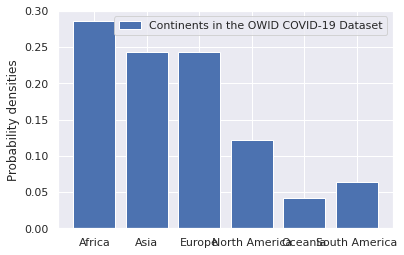

In [21]:
sns.set(font_scale=1)
pmf = Pmf.from_seq(cvd['continent'])
pmf.bar(label='Continents in the OWID COVID-19 Dataset')

plt.ylabel('Probability densities')
plt.legend();

The PMF shows us the various continents and their frequences. As a consequence, the figure also gives us an idea of how the continents rank in terms of number of countries. We could say that Africa has the most countries, followed by Europe, and then Asia, North America, South America and Oceania. 

**Location**

[link text](https://)Plotting the PMF For the location. 

**Total Deaths**

Describing the distribution of the total deaths. 

In [22]:
cvd['total_deaths'].describe()

count       173.000000
mean       7628.838150
std       26672.974531
min           1.000000
25%          90.000000
50%         530.000000
75%        2345.000000
max      246435.000000
Name: total_deaths, dtype: float64

Plotting the CDF for the total deaths.

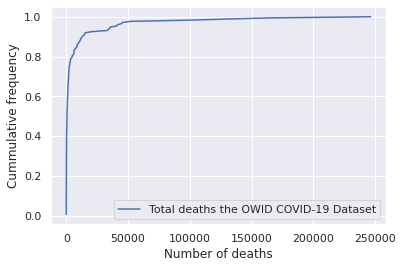

In [23]:
cdf = Cdf.from_seq(cvd['total_deaths'])
cdf.plot(label='Total deaths the OWID COVID-19 Dataset')

plt.ylabel('Cummulative frequency')
plt.xlabel('Number of deaths')
plt.legend();

From the figure, we can see that a very few number of countries contribute for the most deaths around the world. Around 98% of the countries have not more than 50,000 deaths. 

**Total deaths per million**

Describing the total deaths per million

In [24]:
cvd['total_deaths_per_million'].describe()

count     173.000000
mean      196.916139
std       265.316784
min         0.084000
25%        16.213000
50%        73.260000
75%       262.013000
max      1244.304000
Name: total_deaths_per_million, dtype: float64

The standard deviation for the number of deaths per million is smaller than the standard deviation for the number of deaths by almost a factor of 100. This may indicate that the most populated nations recorded more deaths. 

Plotting the CDF for the total deaths per million. 

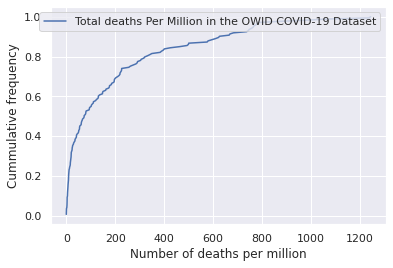

In [25]:
cdf = Cdf.from_seq(cvd['total_deaths_per_million'])
cdf.plot(label='Total deaths Per Million in the OWID COVID-19 Dataset')

plt.ylabel('Cummulative frequency')
plt.xlabel('Number of deaths per million')
plt.legend();

About 50% of the countries have less than 200 deaths per million. 

**Total Number of Cases**

Describing the total number of cases. 

In [26]:
cvd['total_cases'].describe()

count    1.880000e+02
mean     2.903433e+05
std      1.142502e+06
min      1.000000e+00
25%      4.233250e+03
50%      2.746300e+04
75%      1.258482e+05
max      1.109439e+07
Name: total_cases, dtype: float64

Plotting the CDF for the total number of cases. 

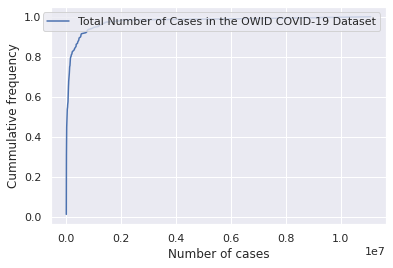

In [27]:
cdf = Cdf.from_seq(cvd['total_cases'])
cdf.plot(label='Total Number of Cases in the OWID COVID-19 Dataset')

plt.ylabel('Cummulative frequency')
plt.xlabel('Number of cases')
plt.legend();

From the figure, we can see that a very few number of countries contribute for a greater fraction of the number of cases around the world. Around 98% of the countries have not more than 2,000,000 cases.

**Total Number of Cases Per Million**

Describing the total number of cases per million

In [28]:
cvd['total_cases_per_million'].describe()

count      188.000000
mean     10087.560761
std      12704.372481
min          3.256000
25%        694.804250
50%       5249.246000
75%      15098.933000
max      75998.188000
Name: total_cases_per_million, dtype: float64

The standard deviation for the number of cases per million is smaller than the standard deviation of the total number of cases by almost a factor of 100. Again this indicates that the more populated geographical locations (countries) may be recording more cases. 

Plotting the CDF for the number of cases per million. 

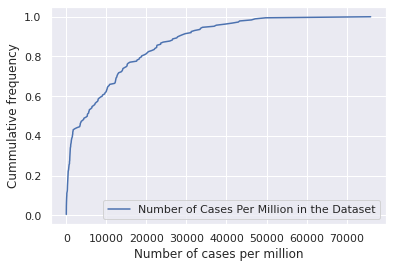

In [29]:
 cdf = Cdf.from_seq(cvd['total_cases_per_million'])
cdf.plot(label='Number of Cases Per Million in the Dataset')

plt.ylabel('Cummulative frequency')
plt.xlabel('Number of cases per million')
plt.legend();

About 80% of the countries, have less than 20,000 cases per million. 

**Total Tests**

Describing the total tests. 

In [30]:
cvd['total_tests'].describe()

count    9.200000e+01
mean     7.084668e+06
std      2.323589e+07
min      1.459200e+04
25%      5.056712e+05
50%      1.534915e+06
75%      3.936134e+06
max      1.730177e+08
Name: total_tests, dtype: float64

Plotting the CDF for the total number of tests. 

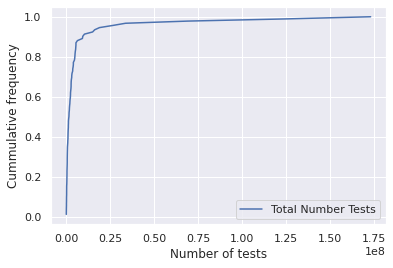

In [31]:
cdf = Cdf.from_seq(cvd['total_tests'])
cdf.plot(label='Total Number Tests')

plt.ylabel('Cummulative frequency')
plt.xlabel('Number of tests')
plt.legend();

The figure indicates that a very select few countries contribute the most to the total number of tests done in the whole world. About 98% of the countries in the world have administered less than 25 million tests. 

**Total tests per thousand**

Describing the total number of tests per thousand. 

In [32]:
cvd['total_tests_per_thousand'].describe()

count      92.000000
mean      233.153870
std       318.854017
min         3.584000
25%        30.620250
50%       140.634500
75%       304.952500
max      1979.194000
Name: total_tests_per_thousand, dtype: float64

The standard deviation for the number of tests per thousand is smaller than the standard deviation of the total number of tests by almost a factor of 60,000 Again this indicates that the more populated geographical locations (countries) may administering more tests. 

Plotting the CDF for the number of tests per thousand. 

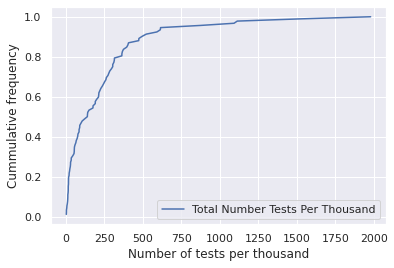

In [33]:
cdf = Cdf.from_seq(cvd['total_tests_per_thousand'])
cdf.plot(label='Total Number Tests Per Thousand')

plt.ylabel('Cummulative frequency')
plt.xlabel('Number of tests per thousand')
plt.legend();

The figure indicates that only about 20% of the countries in the world have carried out more than 250 tests for each thousand people. 

**Average Stringency Index**

The Stringency Index a composite measure of nine of the response metrics.

The nine metrics used to calculate the Government Stringency Index are: school closures; workplace closures; cancellation of public events; restrictions on public gatherings; closures of public transport; stay-at-home requirements; public information campaigns; restrictions on internal movements; and international travel controls.

As was described above, we have calculated the average stringency for each country from the start of the pandemic to November 15th. This value gives us an idea of how well the government is doing in non-testing attempts to contain COVID-19.

Describing the stringency index. 

In [34]:
cvd['average_stringency_index'].describe()

count    170.000000
mean      53.263302
std       12.550495
min       12.260403
25%       45.199128
50%       55.336172
75%       61.976099
max       80.624966
Name: average_stringency_index, dtype: float64

Plotting the CDF for the Stringency Index. 

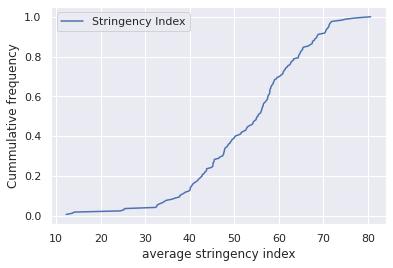

In [35]:
cdf = Cdf.from_seq(cvd['average_stringency_index'])
cdf.plot(label='Stringency Index')


plt.ylabel('Cummulative frequency')
plt.xlabel('average stringency index')
plt.legend();

**Population**

Describing the population

In [36]:
cvd['population'].describe()

count    1.890000e+02
mean     4.098638e+07
std      1.497088e+08
min      8.090000e+02
25%      2.225728e+06
50%      9.449321e+06
75%      2.982597e+07
max      1.439324e+09
Name: population, dtype: float64

Plotting a CDF for the population

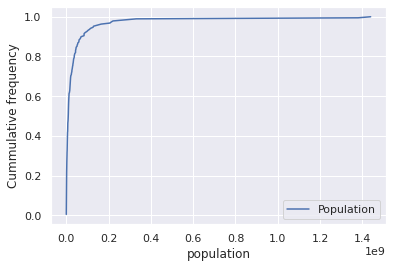

In [37]:
cdf = Cdf.from_seq(cvd['population'])
cdf.plot(label='Population')

plt.ylabel('Cummulative frequency')
plt.xlabel('population')
plt.legend();

The figure indicates that about 98% of the countries in the world have a population of less than 200 million. 

**GDP Per Capita**

Describing the GDP per Capita

In [38]:
cvd['gdp_per_capita'].describe()

count       181.000000
mean      18325.511674
std       19468.608748
min         661.240000
25%        3823.194000
50%       11803.431000
75%       26382.287000
max      116935.600000
Name: gdp_per_capita, dtype: float64

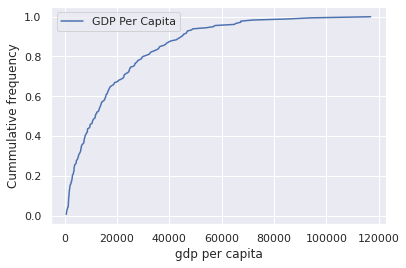

In [39]:
cdf = Cdf.from_seq(cvd['gdp_per_capita'])
cdf.plot(label='GDP Per Capita')


plt.ylabel('Cummulative frequency')
plt.xlabel('gdp per capita')
plt.legend();

The figure indicates that about 60% of the countries in the world have a GDP per capita of no more than $20, 0000. 

**Test efficieny**


Describing the test efficiency. 

For South Korea and other countries that have contained the virus better than the rest of the world, a large number of tests are carried for each reported case of COVID-19. The ratio of positive cases to the number of tests in these countries can be well below 1%. A country is, therefore, said to be testing effectively if the ratio of it's total positive cases to its total number of tests carried out is small. 

This means that for the variable test efficiency, as used in this project, the smaller the value, the more efficient the country is at testing. 

In [40]:
cvd['test_eff'].describe()

count    92.000000
mean     90.319013
std      11.444994
min      21.018924
25%      87.408445
50%      93.280492
75%      97.250201
max      99.830364
Name: test_eff, dtype: float64

Plotting the CDF for the test efficieny. 

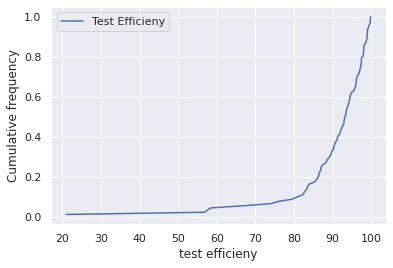

In [41]:
cdf = Cdf.from_seq(cvd['test_eff'])
cdf.plot(label='Test Efficieny')


plt.ylabel('Cumulative frequency')
plt.xlabel('test efficieny')
plt.legend();

**Average Stringency Index and Continent**

We will like to know how the continents compare by average stringency index. This is important as it gives us as a fair idea of how the continents are doing with other approaches to contain the spread of COVID-19 aside testing. 

In [42]:
sns.set(font_scale=1)
by_continent = cvd.groupby('continent')

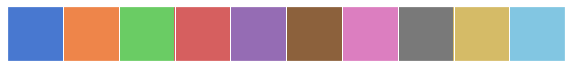

In [43]:
muted = sns.color_palette('muted', 10)
sns.palplot(muted)

Mapping the colours.

In [44]:
color_map = {'Africa': muted[0], 
              'Asia': muted[1], 
               'Europe': muted[2],
             'North America': muted[3],
             'Oceania': muted[4],
             'South America': muted[5]}

Plotting the PMF for the stringency index on a continental basis.

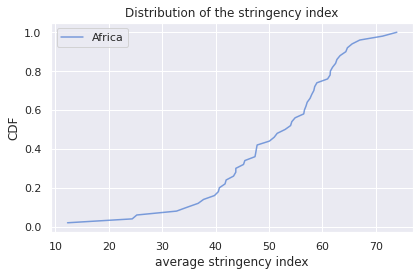

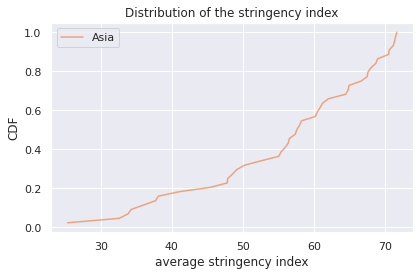

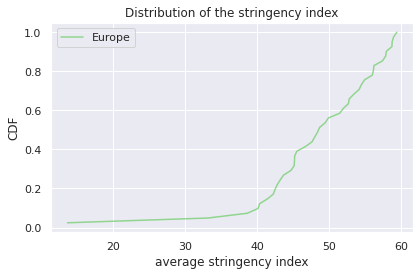

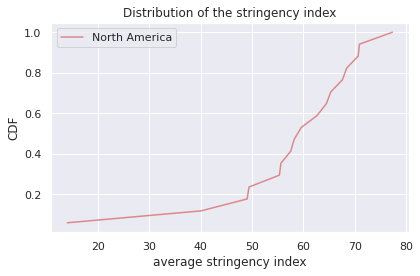

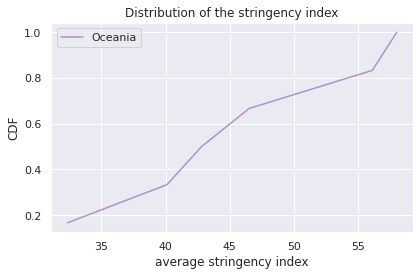

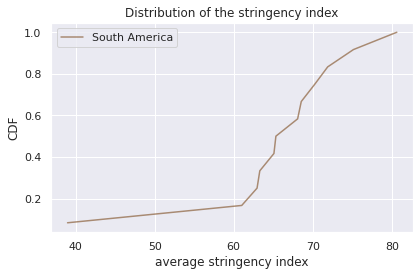

In [45]:
for name in color_map:
    group = by_continent.get_group(name)
    
    plt.figure()
    cdf = Cdf.from_seq(group['average_stringency_index'])
    cdf.plot(label=name, color=color_map[name], alpha=0.7)
    
    decorate(xlabel='average stringency index',
             ylabel='CDF',
             title='Distribution of the stringency index')
    
    plt.legend()

Plotting a graph of the average Stringency Index per continent. 
Because the stringency index is a continuous variable, the mean by group will be intepretable and hence there is no need for recoding. 

In [46]:
means = by_continent['average_stringency_index'].mean()
means

continent
Africa           50.970944
Asia             55.973016
Europe           48.540058
North America    58.008497
Oceania          45.986963
South America    65.932735
Name: average_stringency_index, dtype: float64

In [47]:
names = color_map.keys()
names

dict_keys(['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'])

Plotting the graph

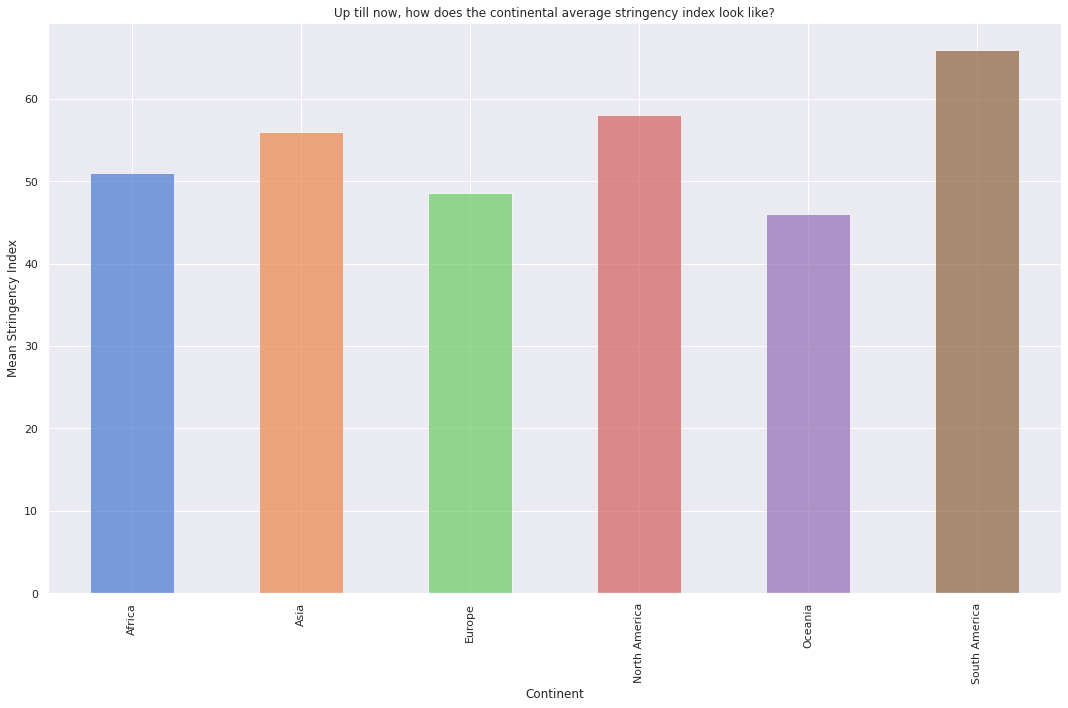

In [48]:
colors = color_map.values()

means[names].plot(kind='bar', color=colors, alpha=0.7, figsize=(15,10))

decorate(xlabel='Continent',
         ylabel='Mean Stringency Index',
         title='Up till now, how does the continental average stringency index look like?')

plt.xticks(rotation='90');

The figure above indicates that if we were to rank the continents according how much they are using the nine factors highlighted above in an attempt to contain COVID-19, the order will be: South America, North America, Asia, Africa, Europe and lastly Oceania. 

**How are the continents doing with testing?**


In [49]:
test_means = by_continent['test_eff'].mean()
test_means


continent
Africa           92.719987
Asia             92.944671
Europe           93.467833
North America    84.917077
Oceania          99.764885
South America    68.527068
Name: test_eff, dtype: float64

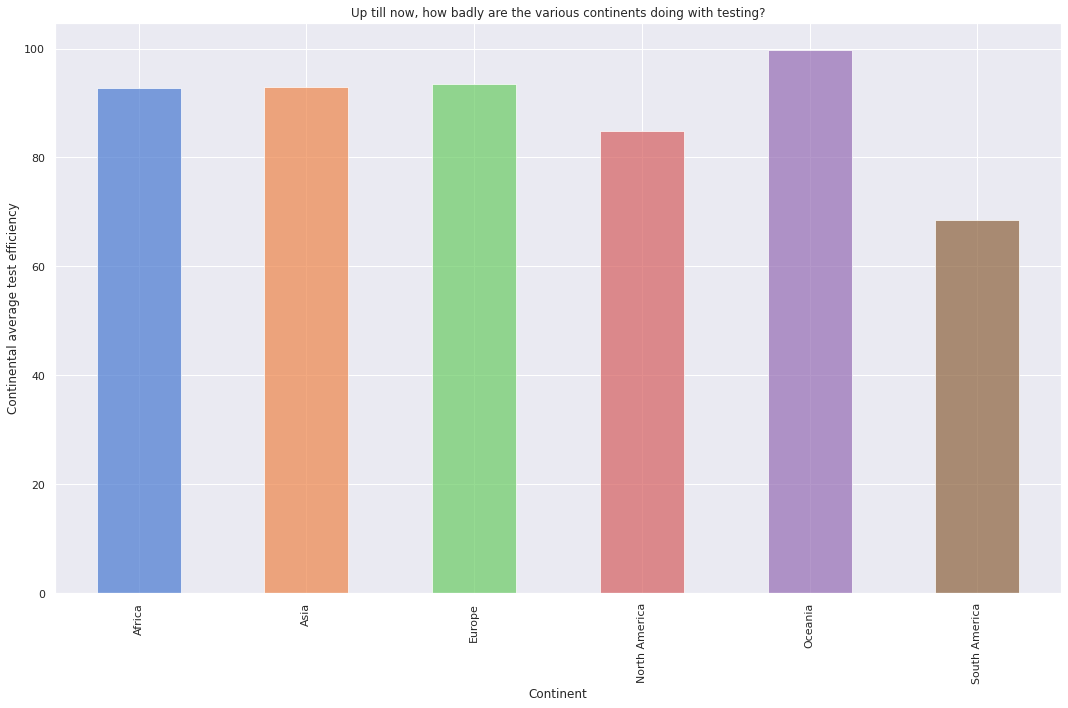

In [50]:
colors = color_map.values()

test_means[names].plot(kind='bar', color=colors, alpha=0.7, figsize=(15,10))

decorate(xlabel='Continent',
         ylabel='Continental average test efficiency',
         title='Up till now, how badly are the various continents doing with testing?')

plt.xticks(rotation='90');

The figure above represents the average test efficiency on a continental basis. The height of the bar indicates how effectively a continent is testing, and is measured on a hundred.

This, therefore, means that in comparing the continents, South America is the worst with testing, followed by North America, Africa, Asia, Europe and Oceania in that order. 

**Looking at Testing and the stringency index side-by-side**

Although testing is a tested approach to controlling the spread of the virus, other non-testing strategies such as lockdowns may be employed. Placing the testing efficiency side-by-side the stringency index, we will like to know how the various continents, on average, are combining these two main approaches in an attempt to control COVID-19.

In [51]:

continent_df = [{"continent": "Africa"}, {"continent": "Asia"}, {"continent":"Europe"}, {"continent":"North America"}, {"continent":"Oceania"}, {"continent": "South America" }]
df = pd.DataFrame(continent_df)

for i,m in means.items():
  df.loc[df['continent'] == i, 'average_stringency_index'] = m
for i,m in test_means.items():
  df.loc[df['continent'] == i, 'average_test_eff'] = m
  df.loc[df['continent'] == i, 'group'] = i


In [52]:
df.head()

,continent,average_stringency_index,average_test_eff,group
0,Africa,50.970944,92.719987,Africa
1,Asia,55.973016,92.944671,Asia
2,Europe,48.540058,93.467833,Europe
3,North America,58.008497,84.917077,North America
4,Oceania,45.986963,99.764885,Oceania


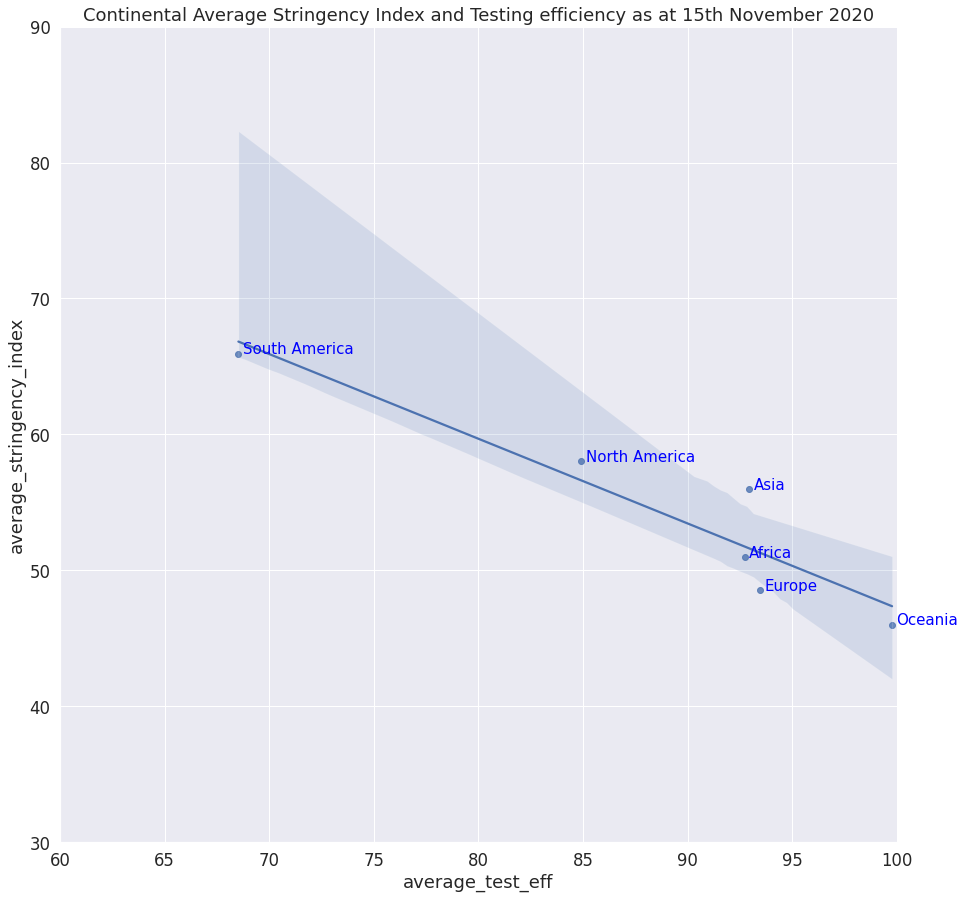

In [53]:
sns.set_style('ticks')
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(15,15)
plt.ylim(30, 90)
plt.xlim(60,100)
plt.title("Continental Average Stringency Index and Testing efficiency as at 15th November 2020")
p = sns.regplot(data=df, x=df["average_test_eff"], y=df["average_stringency_index"], marker="o", fit_reg=True)
for line in range(0,df.shape[0]):
     p.text(df.average_test_eff[line]+0.2, df.average_stringency_index[line], df.group[line], horizontalalignment='left', size='small', color='blue', weight='light')
sns.despine()

The scatterplot indicates that there is an inverse relationship between the average stringency index and the average test efficiency. Let us confirm that by calculating the coefficient of correlation. 

In [54]:
df['average_stringency_index'].corr(df['average_test_eff'])

-0.9381271256159555

The correlation coefficient indicates that there is indeed a relationship, and it is a strong one.

What about the number of persons getting COVID in each continent?

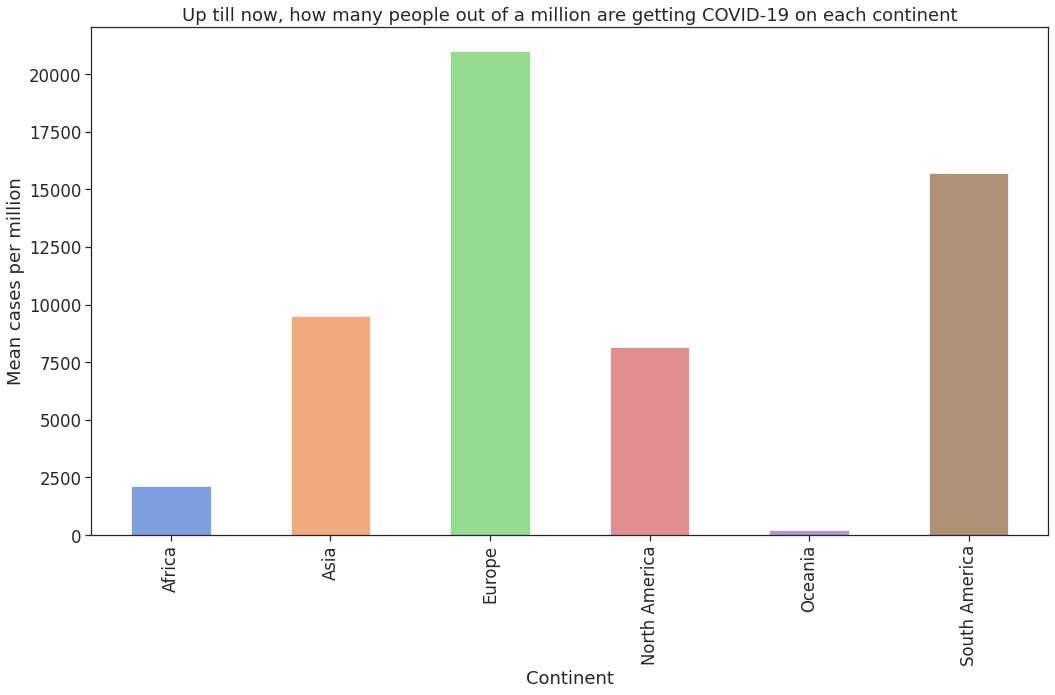

In [ ]:
colors = color_map.values()
case_means = by_continent['total_cases_per_million'].mean()
case_means[names].plot(kind='bar', color=colors, alpha=0.7, figsize=(15,10))

decorate(xlabel='Continent',
         ylabel='Mean cases per million',
         title='Up till now, how many people out of a million are getting COVID-19 on each continent')

plt.xticks(rotation='90');

**What about the relationship between the stringency index and the test efficiency for all countries? Is there a relationship?**

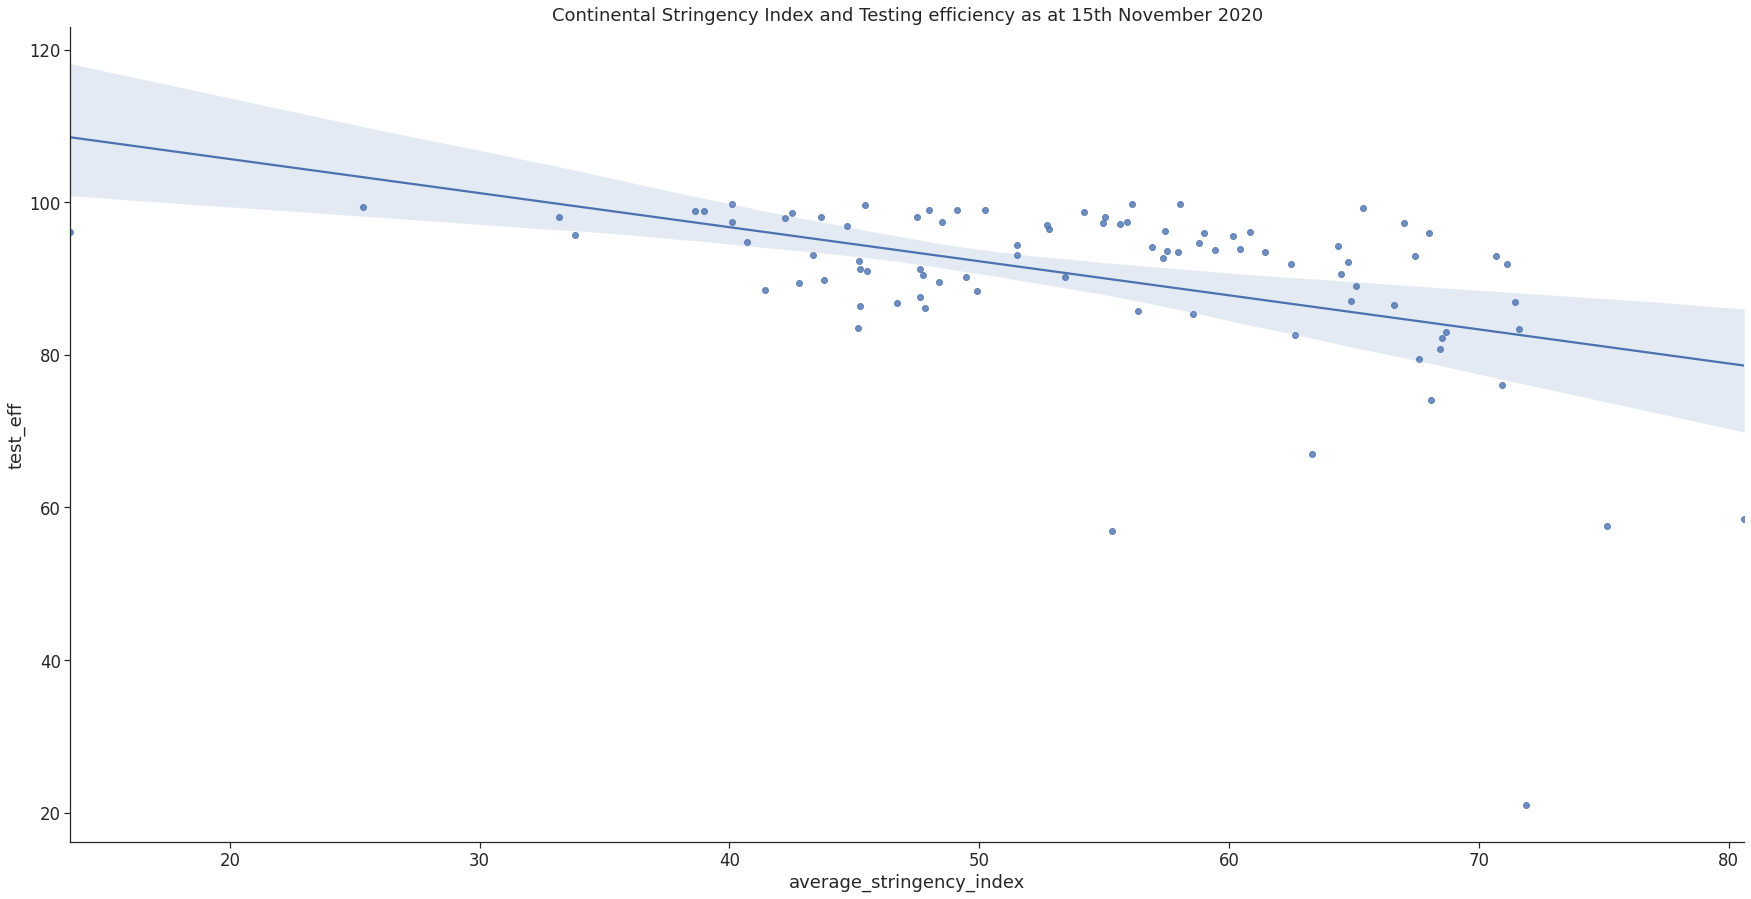

In [ ]:

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
plt.title("Continental Stringency Index and Testing efficiency as at 15th November 2020")
p2 = sns.regplot(data=cvd, x=cvd["average_stringency_index"], y=cvd["test_eff"], marker="o", fit_reg=True)
sns.despine()

There appears to be an inverse relationship between the test efficiency and the average stringency index. Let us proceed to calculate the coefficient of correlation. 

In [57]:
cvd['average_stringency_index'].corr(cvd['test_eff'])

-0.45275413239841905

**Looking at the average stringency index and the total cases per million.**

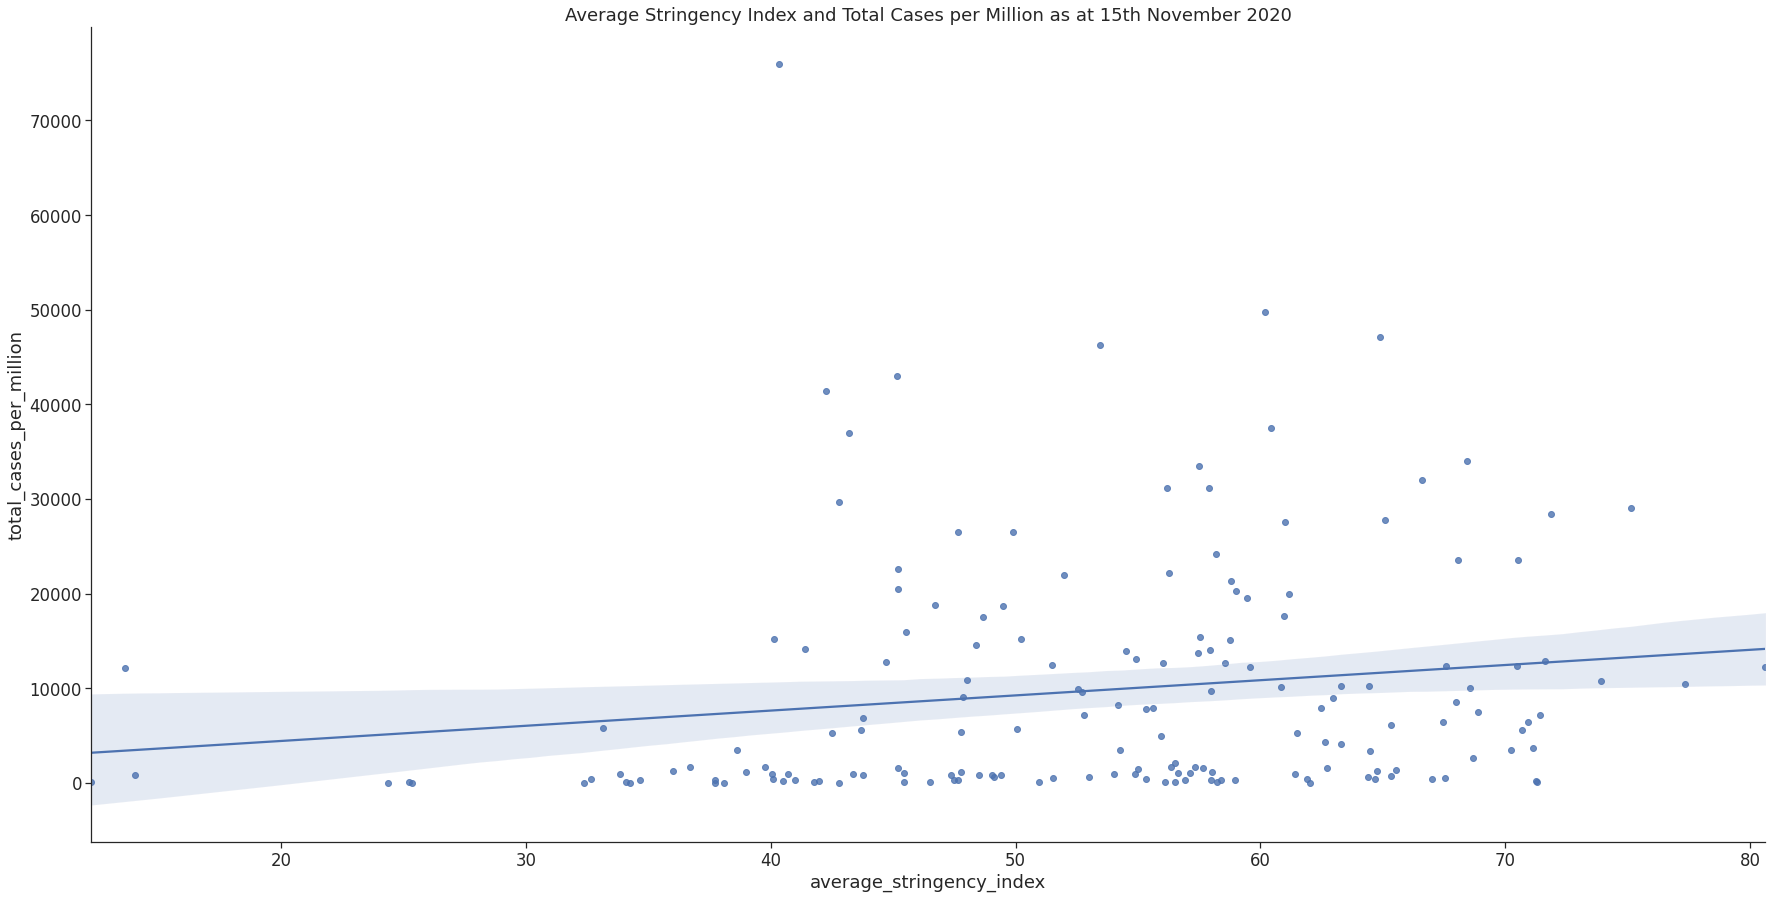

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
plt.title("Average Stringency Index and Total Cases per Million as at 15th November 2020")
p2 = sns.regplot(data=cvd, x=cvd["average_stringency_index"], y=cvd["total_cases_per_million"], marker="o", fit_reg=True)
sns.despine()

Finding the correlation coefficient. 

In [59]:
cvd['total_cases_per_million'].corr(cvd['average_stringency_index'])

0.16213007267828222

**Looking at the GDP per Capita and the total tests per thousand**

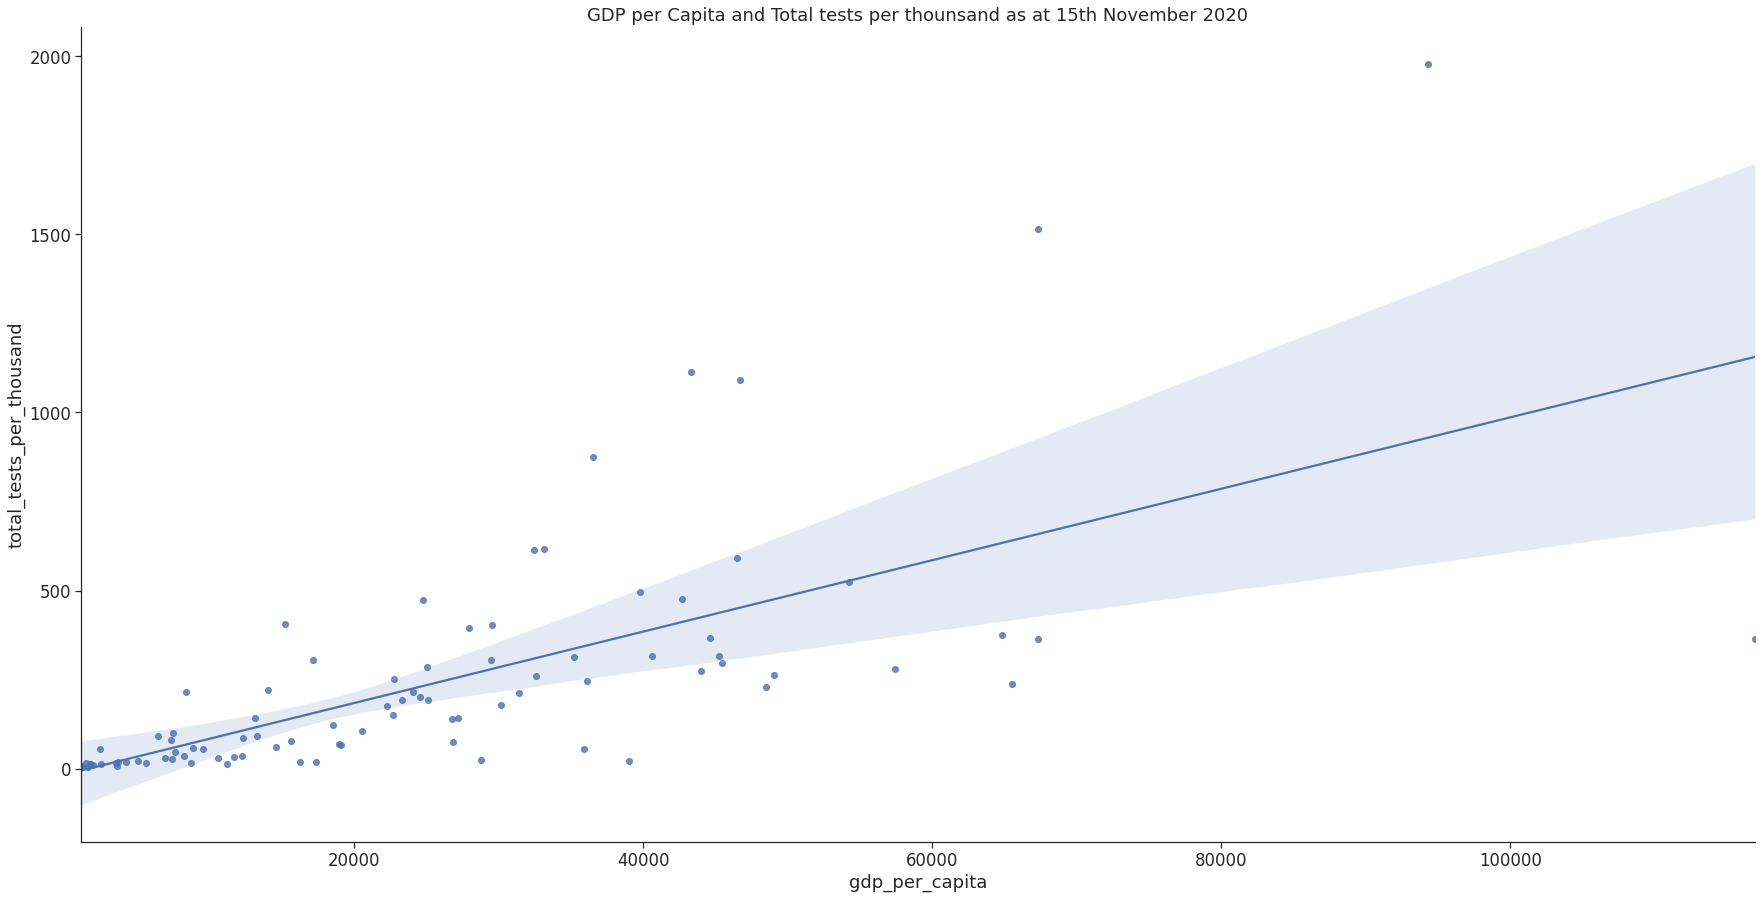

In [ ]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
plt.title("GDP per Capita and Total tests per thounsand as at 15th November 2020")
p2 = sns.regplot(data=cvd, x=cvd["gdp_per_capita"], y=cvd["total_tests_per_thousand"], marker="o", fit_reg=True)
sns.despine()

Calculating the correlation coefficient

In [61]:
cvd['total_tests_per_thousand'].corr(cvd['gdp_per_capita'])

0.6645994081597799